In [1]:
import sys
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import datetime
from tqdm import tqdm
import GPy
from collections import defaultdict
from pathlib import Path
import seaborn as sns
import scipy.stats as stats
from matplotlib.colors import ListedColormap
import warnings
import time
from itertools import product
from joblib import Parallel, delayed
from operator import itemgetter
import sncosmo
import emcee
import corner
import pickle

mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.autolayout'] = True
# mpl.rcParams['figure.dpi'] = 300
# mpl.rcParams['axes.spines.right'] = False
# mpl.rcParams['axes.spines.top'] = False


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})


def utkarshGrid():
    plt.minorticks_on()
    plt.grid(color='grey',
             which='minor',
             linestyle=":",
             linewidth='0.1',
             )
    plt.grid(color='black',
             which='major',
             linestyle=":",
             linewidth='0.1',
             )
    
# set random number seed to ensure reproducibility
seed = 3
rstate = np.random.RandomState(seed)

## Implementing MCMC using GP Emulator Model

In [2]:
path = os.path.dirname(os.getcwd())
os.chdir(path)
from Emulator.Classes.AllData import AllData
from Emulator.Classes.LightCurve import utkarshGrid, LightCurve
from Emulator.Classes.GP import GP
from Emulator.Classes.GP2D import GP2D
from Emulator.Classes.GP5D import GP5D
os.chdir(os.getcwd() + "/Emulator")
os.getcwd()

'/Users/utkarsh/PycharmProjects/KilonovaeLightCurves/Emulator'

In [3]:
truth_arr = np.array([0.01, 0.13, 60, 4]) #[mejdyn, mejwind, phi, iobs]
mejdyn_guess, mejwind_guess, phi_guess, iobs_guess = [0.1, 0.1, 20, 9]

In [4]:
def train_fluxes(mejdyn = truth_arr[0], mejwind = truth_arr[1], phi = truth_arr[2], 
                 iobs = truth_arr[3], messages = False):
    curr_wv = np.arange(100, 3600, 10)
    set_skip_factor = None
    gp = GP5D("Classes/reference.csv")
    gp.split = 1
    gp.emulator = "start"
    gp.cross_validation = (mejdyn, mejwind, phi, iobs)
    gp.set_wv_range(curr_wv)
    gp.n_comp = 25
    time_shape = None
    gp.save_pca_components(skip_factor = set_skip_factor)
    gp.setXY_cross_validation(mejdyn, mejwind, phi, iobs, messages = False)
    fitting_kernel = GPy.kern.RBF(input_dim=4, variance = 1, lengthscale=1, ARD = True)
    decay_kernel = GPy.kern.Linear(input_dim=4, ARD = True)
    gp.kernel = fitting_kernel * decay_kernel
    gp.model = GPy.models.GPRegression(gp.X,gp.Y,gp.kernel)
    if messages:
        print(gp.model)
    t0 = time.time()
    if messages:
        print(f"[STATUS] Optimizing...")
    gp.model.optimize(messages = False)
    gp.model_predict(include_like = True, messages = False)
    gp.save_pca_initial_validation()
    gp.delete_folder_files("data/pcaComponentsTrained")
    gp.delete_folder_files("data/pcaComponentsTrainedError")
    return gp

In [5]:
gp = train_fluxes()

In [6]:
def predict_fluxes(mejdyn, mejwind, phi, iobs, gp = gp, extra_item = None):
    gp.validationX = [mejdyn, mejwind, phi, iobs]
    theta = gp.validationX
    gp.model_predict_cross_validation(include_like = True, messages = False) # Save cross validation
    gp.save_trained_data(errors = False, theta = (mejdyn, mejwind, phi, iobs), extra_item = extra_item)
    y = np.load(f"data/pcaTrained/mejdyn{mejdyn}_mejwind{mejwind}_phi{phi}_iobs{iobs}.npy")
    t = gp._t_helper()
    t_matrix = np.repeat(t, gp.num_wv).reshape(len(t), gp.num_wv)
    x = t_matrix
    os.remove(f"data/pcaComponentsTrained/mejdyn{mejdyn}_mejwind{mejwind}_phi{phi}_iobs{iobs}.npy")
    os.remove(f"data/pcaComponentsTrainedError/mejdyn{mejdyn}_mejwind{mejwind}_phi{phi}_iobs{iobs}.npy")
    return x, y

In [7]:
x, y = predict_fluxes(mejdyn = truth_arr[0], mejwind = truth_arr[1], 
                      phi = truth_arr[2], iobs = truth_arr[3], extra_item = True)
yerr = 0.2 * y
print(x.shape, y.shape)

(100, 350) (100, 350)


In [8]:
def prior(theta):
    """log-prior as a function of parameters `theta`.""" 
    mejdyn, mejwind, phi, iobs = theta
    lim = 1e6
    if mejdyn > 1 or mejdyn < 0.001:
        return -np.inf
    elif mejwind > 1 or mejwind < 0.001:
        return -np.inf
    elif phi > 91 or phi < 0:
        return -np.inf
    elif iobs > 11 or iobs < 0:
        return -np.inf
    else:
        return 0.0

def loglike(theta, x, y, yerr):
    """log-likelihood as a function of parameters `theta`."""
    
    mejdyn, mejwind, phi, iobs = theta
    x, y_model = predict_fluxes(mejdyn, mejwind, phi, iobs)
    logl = - 0.5 * np.sum(((y - y_model)/yerr)**2)
    return logl

def logpost(theta, x=x, y=y, yerr=yerr):
    """(Negative) log-posterior as a function of parameters `theta`."""
    if not np.isfinite(prior(theta)):
        return -np.inf
    mejdyn, mejwind, phi, iobs = theta  # reassign parameters
    logp = prior(theta)  # prior
    logl = loglike(theta, x=x, y=y, yerr = yerr)  # likelihood
    return (logl + logp)  # posterior

In [9]:
initial = [mejdyn_guess, mejwind_guess, phi_guess, iobs_guess]
ndim = len(initial)
nwalkers = 100
nburn = 1
niter = 10


p0 = [np.array(initial) + 1 * np.random.randn(ndim) for i in range(nwalkers)]
p0 = np.array(p0, dtype = float)
print(p0.shape)

sampler = emcee.EnsembleSampler(nwalkers, ndim, logpost)

state = sampler.run_mcmc(p0, nburn)
sampler.reset()

state = sampler.run_mcmc(state, niter, progress=True)

gp.delete_folder_files("data/pcaTrained")

(100, 4)


 /Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning:invalid value encountered in double_scalars
100%|██████████| 10/10 [02:34<00:00, 15.47s/it]


In [10]:
# get final chains
samples = sampler.get_chain()

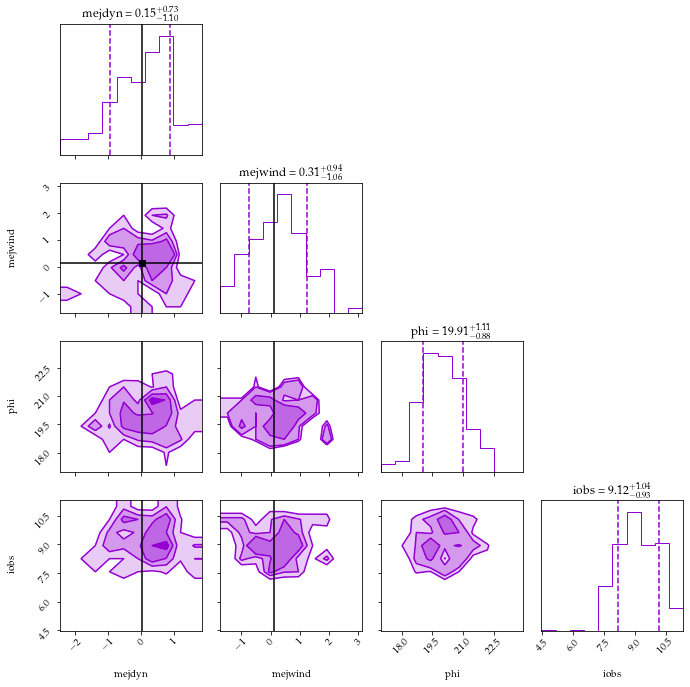

In [11]:
# plot posterior
corner.corner(samples.reshape(-1, ndim),  # collect samples into N x 3 array
              bins=10,  # bins for histogram
              show_titles=True, quantiles=[0.16, 0.84],  # show median and uncertainties
              labels=['mejdyn', 'mejwind', 'phi', "iobs"],
              truths=truth_arr,  # plot truth
              color='darkviolet', truth_color='black',  # add some colors
              **{'plot_datapoints': False, 'fill_contours': True});  # change some default options

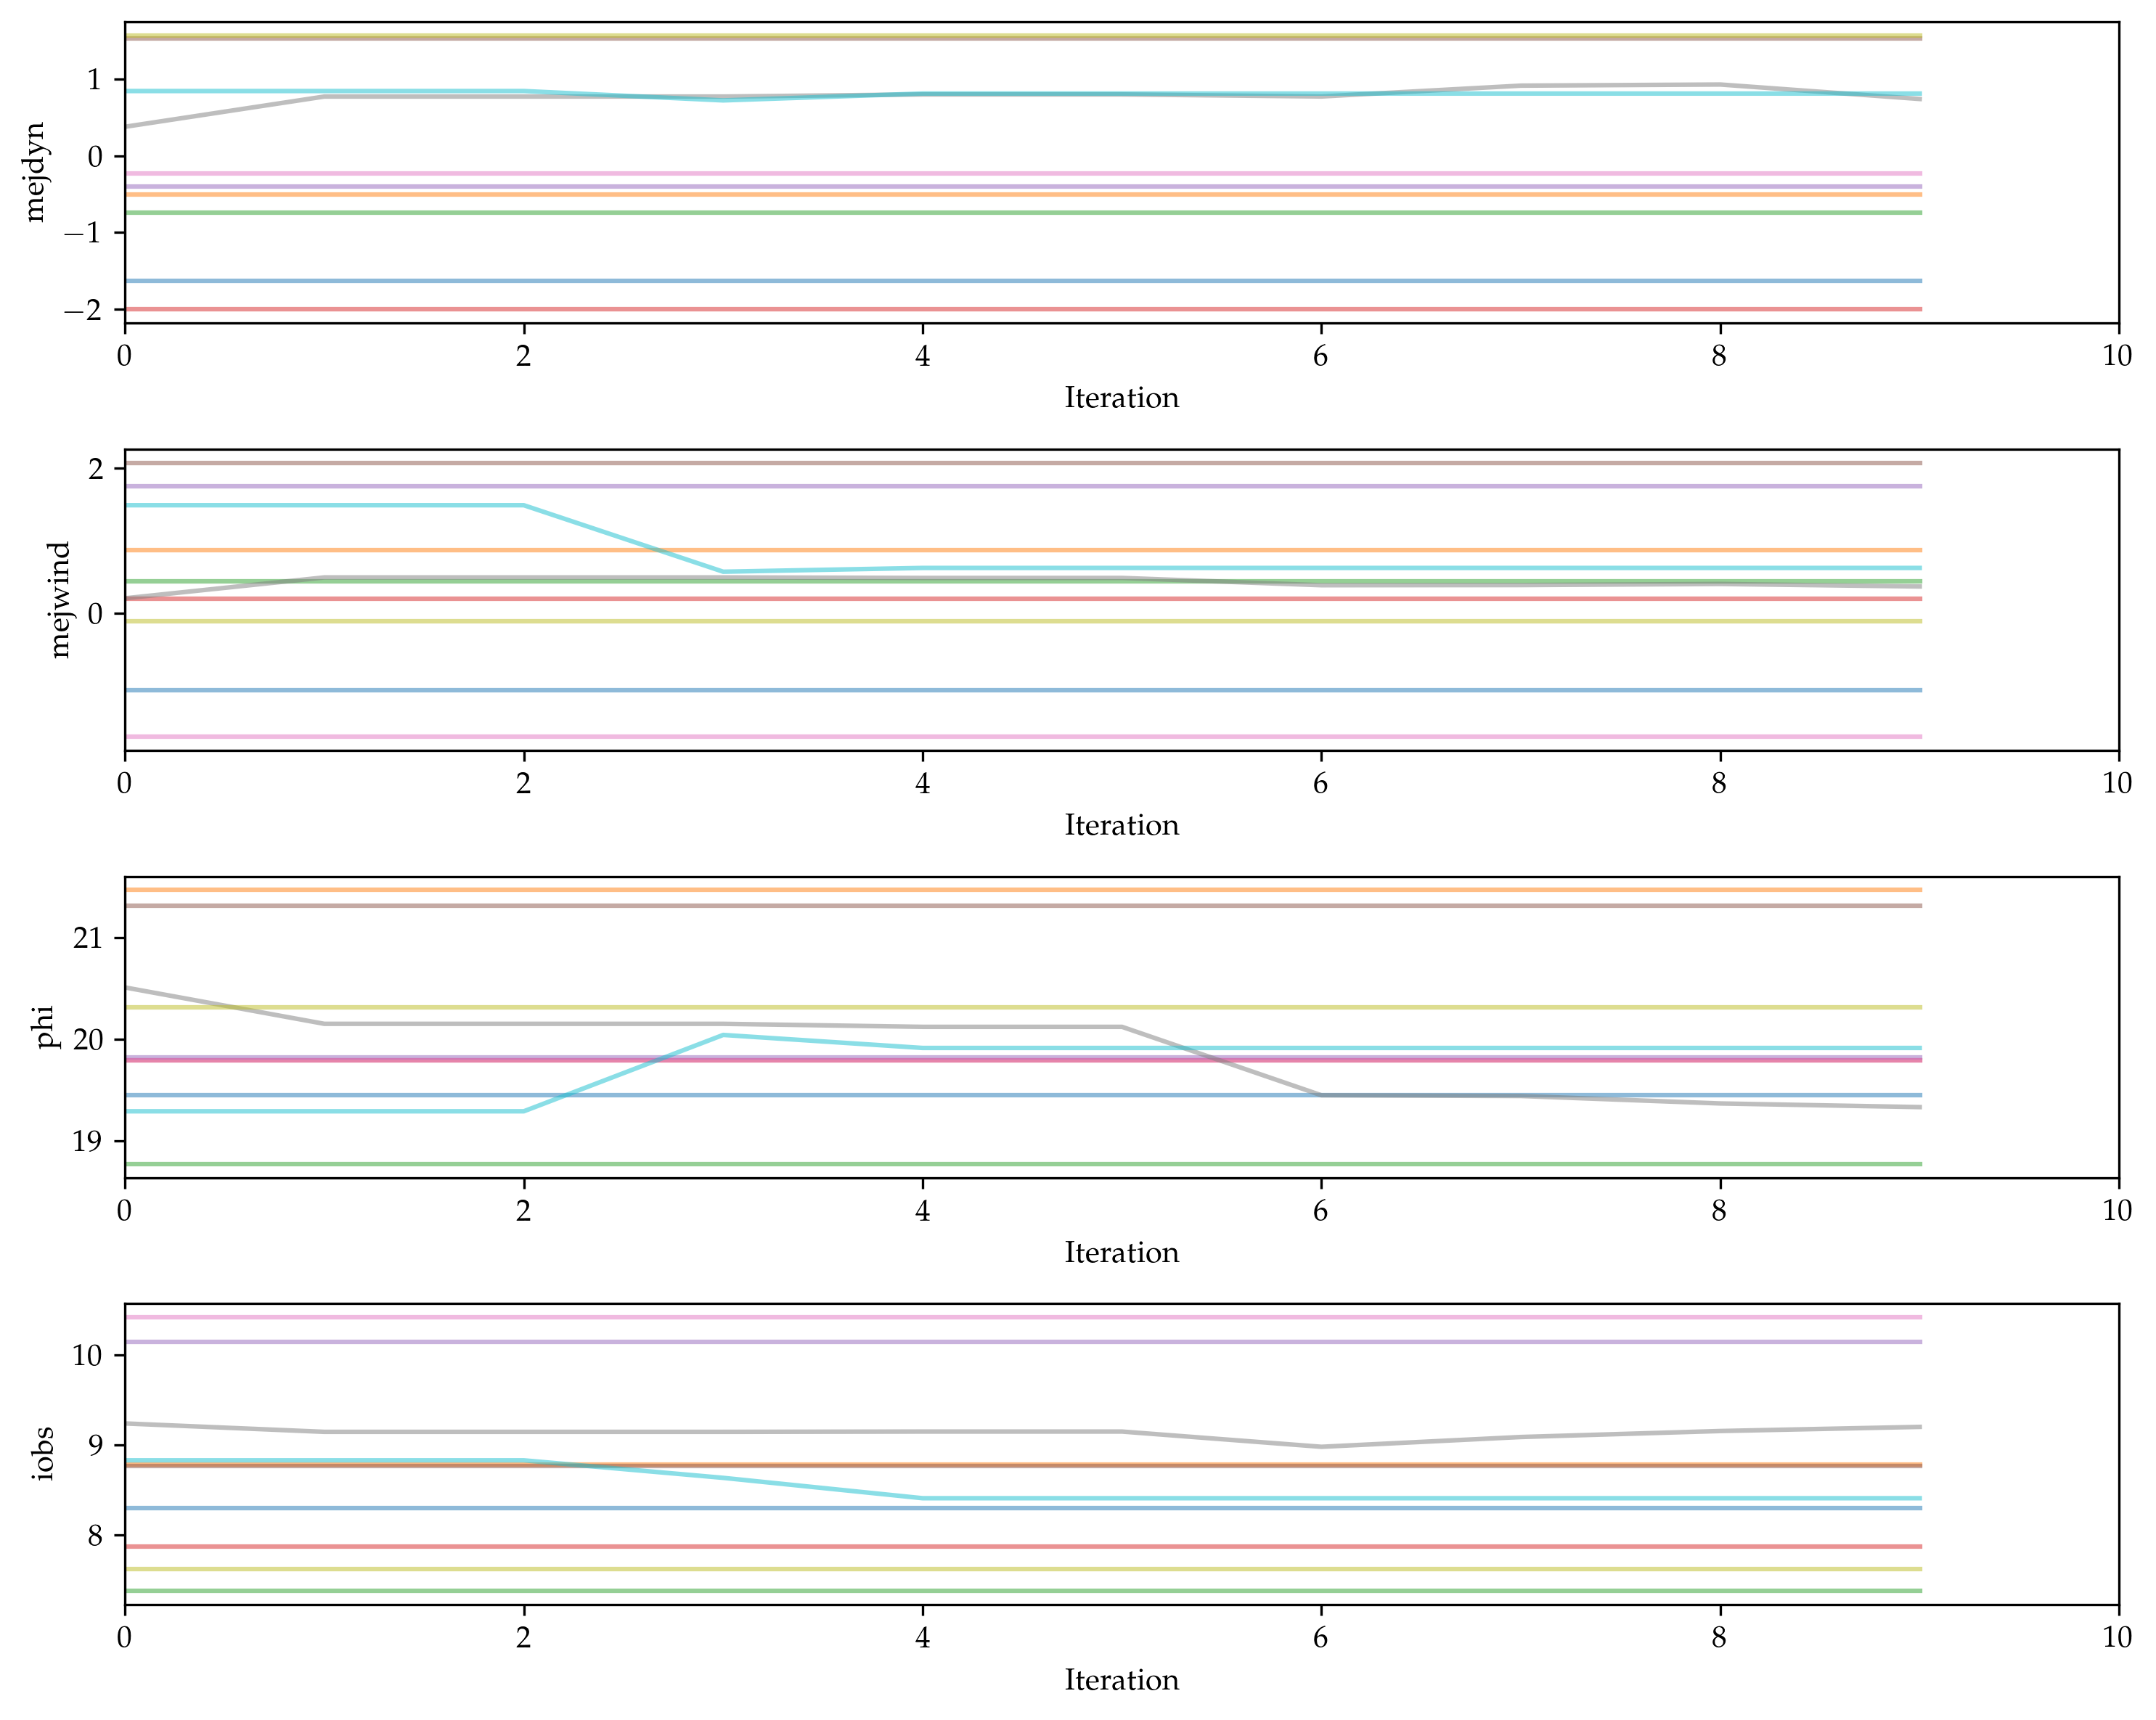

In [12]:
# plot a few chains
walkers = 10
plt.figure(dpi = 300, figsize = (10,8))

plt.subplot(4, 1, 1)
[plt.plot(samples[:, i, 0], alpha=0.5) for i in range(walkers)]
plt.xlim([0, niter])
plt.xlabel('Iteration')
plt.ylabel('mejdyn')

plt.subplot(4, 1, 2)
[plt.plot(samples[:, i, 1], alpha=0.5) for i in range(walkers)]
plt.xlabel('Iteration')
plt.ylabel('mejwind')
plt.xlim([0, niter])

plt.subplot(4, 1, 3)
[plt.plot(samples[:, i, 2], alpha=0.5) for i in range(walkers)]
plt.xlim([0, niter])
plt.xlabel('Iteration')
plt.ylabel('phi')
plt.tight_layout()

plt.subplot(4, 1, 4)
[plt.plot(samples[:, i, 3], alpha=0.5) for i in range(walkers)]
plt.xlim([0, niter])
plt.xlabel('Iteration')
plt.ylabel('iobs')
plt.tight_layout()